In [ ]:
# Get the audio data
!wget -r -np -nH --cut-dirs=3 -R index.html --user=daicwozuser --password= --no-check-certificate  https://dcapswoz.ict.usc.edu/wwwdaicwoz/

In [18]:
from pydub import AudioSegment
from scipy import signal
from sklearn.utils import shuffle
import re
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from librosa import display
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional, GRU, TimeDistributed
from keras.optimizers import *
from keras.engine.input_layer import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import itertools
import math
import time
import os
import json

In [19]:
# Extract the files

import fnmatch
import os
import zipfile
"""
    A script that takes in a zip file and extracts the .wav file and
    transcript.csv files into separate folders in the specified directory.
"""


def extract_files(zip_file, out_dir, delete_zip=False):
 
    # create audio directory
    audio_dir = os.path.join(out_dir, 'audio')
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    # create transcripts directory
    transcripts_dir = os.path.join(out_dir, 'transcripts')
    if not os.path.exists(audio_dir):
        os.makedirs(transcripts_dir)

    zip_ref = zipfile.ZipFile(zip_file)
    for f in zip_ref.namelist():  # iterate through files in zip file
        if f.endswith('.wav'):
            zip_ref.extract(f, audio_dir)
        elif fnmatch.fnmatch(f, '*TRANSCRIPT.csv'):
            zip_ref.extract(f, transcripts_dir)
    zip_ref.close()

    if delete_zip:
        os.remove(zip_file)


if __name__ == '__main__':
    # directory containing DAIC-WOZ zip files
    dir_name = '../../Users/emmanuel.okwiri/'

    # directory where audio and transcripts folders will be created
    out_dir = './depression-detection-extract/data/raw'

    # delete zip file after file wav and csv extraction. Set to true if you want to delete, otherwise, false.
    delete_zip = True

    # iterate through zip files in dir_name and extracts wav and transcripts
    for file in os.listdir(dir_name):
        if file.endswith('.zip'):
            zip_file = os.path.join(dir_name, file)
            extract_files(zip_file, out_dir, delete_zip=delete_zip)


In [3]:
# Function definition to calculate spectograms and confussion matrix

num_classes = 5
data_path = "./depression-detection-extract/data/raw/transcripts/"
audio_path = "./depression-detection-extract/data/raw/audio/"

SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(np.abs(stft))

def soundwave_to_np_spectrogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
    return Xdb

In [4]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [5]:
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [20]:
 # Split 70, 14 and 16 for training, dev & test

train = load_avec_dataset_file('./depression-detection-extract/data/train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('./depression-detection-extract/data/dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('./depression-detection-extract/data/full_test_split.csv', 'PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


### Audio segmentation & speaker diarization

In [7]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [8]:
ds_total.to_csv(data_path + 'ds_total.csv', sep='\t')
print("File created")

File created


### Removing Ellie's voice from the interview

In [9]:
# Segmenting the audio for each paricipant

"""
The segmentation is done using the transcripts that the database provides for each participant.
We use the provided transcripts to diarize out the virtual interviewer's voice.
This is done to achieve better performance in the training and validation of the system
"""

# Segment the audio using the time info of the transcript of each participant, also concatenate
# each segmented audio to the end of the sums of all audios, to create a .wav that only contains
# the audio from the particpant. The audio from the interviewer gets erased using this segmentation.

def segment_audio(ds_total, transcript_directory, audio_directory, audio_output_dir):
    input_array = []
    person_id_list = []
    level_array = []
    
    filenames = os.listdir(transcript_directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        transcript_path = os.path.join(transcript_directory, filename)
        transcript = pd.read_csv(transcript_path, sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = int(m.group(1))            
            person_audio = AudioSegment.from_wav(audio_directory 
                                             + str(person_id) + '_AUDIO.wav')
            lines = len(transcript)
            combined_sounds = AudioSegment.empty()
            for i in range(0, lines):
                row = transcript.iloc[i]
                if row["speaker"] == "Participant":
                    t1 = int(float(row["start_time"]) * 1000)
                    t2 = int(float(row["stop_time"]) * 1000)
                    newAudio = person_audio[t1:t2]
                    combined_sounds += newAudio
                    
            combined_sounds.export(audio_output_dir + str(person_id) + '.wav', format="wav")

            w = AudioSegment.from_wav(audio_output_dir + str(person_id) + '.wav')
            input_array.append(w)
            person_id_list.append(person_id)
            level_array.append(ds_total.loc[ds_total["Participant_ID"] == person_id, "level"].item())
    print(f"Segmentation complete!")
            
    return input_array, person_id_list, level_array

In [10]:
input_array, person_id_list, level_array = segment_audio (ds_total, data_path , audio_path, "./depression-detection-extract/data/segmented_audio/")

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: `item` has been deprecated and will be removed in a future version


Segmentation complete!


## Visualizing sample patient's MFCC

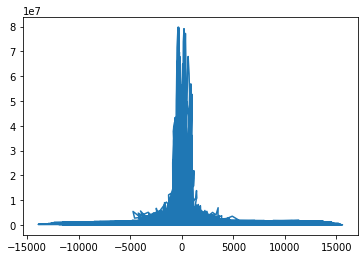

In [31]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
rate, data = wav.read('./depression-detection-extract/data/segmented_audio/300.wav')
fft_out = fft(data)
%matplotlib inline
plt.plot(data, np.abs(fft_out))
plt.show()

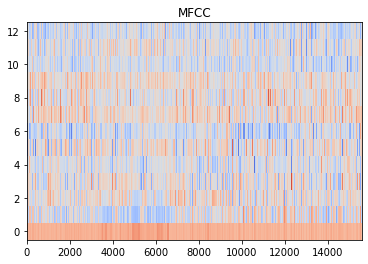

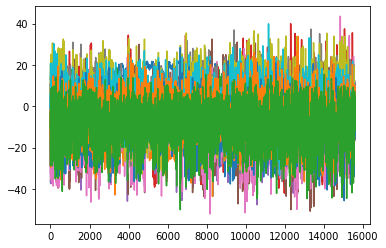

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm

(rate,sig) = wav.read("./depression-detection-extract/data/segmented_audio/300.wav")
mfcc_feat = mfcc(sig,rate)

ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
#Showing mfcc_feat
plt.plot(mfcc_feat)
plt.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


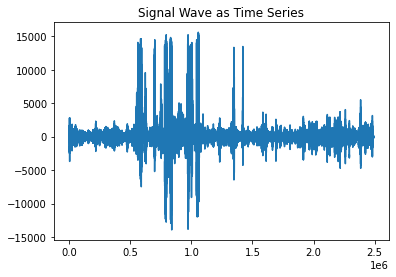

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open("./depression-detection-extract/data/segmented_audio/300.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")


plt.figure(1)
plt.title("Signal Wave as Time Series")
plt.plot(signal)
plt.show()

In [11]:
# Calculation of .wav length so we can move the time window from the start to the end without any problems.

len_list = []
for audio_file in input_array:
    len_list.append(int(len(audio_file) / (1000)))

In [ ]:
print("\n",input_array)
print("\n",person_id_list)
print("\n",level_array)

### Data Augmentation

*We use data augmentation to increase the number of samples to train the system. We take a time window and move it along the .wav that was segmented. We create 10 samples, each 7 minutes long for each segmented .wav file. Also we add the PHQ-8 score (predicted value) of each new sample.*

In [12]:
person_id_list_extended = []
trim_array = []
level_array_extended = []
stride = 15
time_window = 7
n_samples_max = 10

path = "./depression-detection-extract/data/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) +"/"

if not os.path.exists(path):
    os.makedirs(path)

for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
    n_samples = min(n_samples_max, int((len(audio_file) - time_window * 1000)/(stride * 1000)))
    t1_ini = 0
    t2_end = time_window * 1000
    for i in range(n_samples):
        t1_ini = t1_ini + stride * 1000
        t2_end = t2_end + stride * 1000
        audio_trim = audio_file[t1_ini:t2_end]
        trim_array.append(audio_trim)
        person_id_list_extended.append(person_id)
        level_array_extended.append(level)
        audio_trim.export(path + str(person_id) + '_' + str(i) + '.wav', format="wav")

In [23]:
len(trim_array)

1869

In [24]:
person_id_list_padded = []
padded_array = []
level_array_padded = []
max_size = max(len_list)
mean_size = np.mean(len_list)
min_size = min(len_list)
for audio_file, person_id, level in zip(input_array, person_id_list, level_array):  
    padding = AudioSegment.silent(duration = min_size * 1000)
    audio_trim = padding.overlay(audio_file)
    padded_array.append(audio_trim)
    person_id_list_padded.append(person_id)
    level_array_padded.append(level)
    audio_trim.export("./depression-detection-extract/data/audio_cut_padded/mean/" + str(person_id) + '.wav', format="wav")


### Spectograms creation for each audio sample

In [15]:
# Read the audio sample and calculate the normalized spectrogram

X, sr = librosa.load(path + '303' + '_' + '1' + '.wav')
sample = soundwave_to_np_spectrogram(X)
sample = sample[0:95,:]
sample.shape

(95, 2412)

In [25]:
sample.size

2755569

*The spectogram shows the information of the audio in the frequency domain. The frequencies shown are up to ~3600 MHz*

In [26]:
X, sr = librosa.load('./depression-detection-extract/data/audio_cut_padded/mean/' + '303' + '.wav')
sample = soundwave_to_np_spectrogram(X)

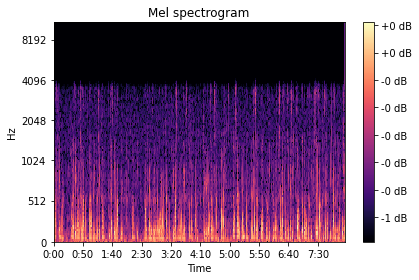

In [24]:
# Show the sample spectrogram of participant 303

librosa.display.specshow(sample,
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [29]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ 
    Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ 
    Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

In [30]:
"""
Create Spectograms of each segmented audio
"""
dataset_path = path
filenames = os.listdir(dataset_path)

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

sort_nicely(filenames)
Xdb = []    
    
for filename in filenames:
    X, sr = librosa.load(dataset_path + filename)
    X = abs(soundwave_to_np_spectrogram(X))
    X = X[0:95,:]
    Xdb.append(X)

In [31]:
spec_path = "./depression-detection-extract/data/spectrogram/audio_augmented/time_window_" + str(time_window) + "_stride_" + str(stride) + "_max_" + str(n_samples_max) + "/"

if not os.path.exists(spec_path):
    os.makedirs(spec_path)

np.asarray(Xdb).dump(open(spec_path +"Xdb.npy", "wb"))
np.asarray(level_array_extended).dump(open(spec_path + 'Y.npy', 'wb'))

In [32]:
number_of_files = int(len(Xdb)/500)
for i in range(number_of_files):
    start = i * 500
    end = start + 500 if start + 500 < len(Xdb) else len(Xdb)
    np.asarray(Xdb[start:end]).dump(open('./depression-detection-extract/data/spectrogram/audio_augmented/time_window_7_stride_15_max_10/Xdb_' + str(i) + '.npy', 'wb'))
    np.asarray(level_array_extended[start:end]).dump(open('./depression-detection-extract/data/spectrogram/audio_augmented/time_window_7_stride_15_max_10/Y_' + str(i) + '.npy', 'wb'))

In [33]:
# Calculate size of the spectrogram. Every sample has the same length so only 1 size is calculated.

alto, ancho = Xdb[0].shape
print(alto, ancho)

95 2412


### Reshaping the data to be input to the model
*We reshape the spectogram matrix to feed it in an LSTM network or a Convolutional network.*

In [34]:
level_array_extended_new = np.asarray(level_array_extended)
print(np.asarray(Xdb).shape)
print(level_array_extended_new.shape)
len(Xdb)

(1869, 95, 2412)
(1869,)


1869

In [35]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

np.unique(level_array_extended_new, return_counts=True)

(array([0, 1, 2, 3, 4]), array([255, 697, 461, 240, 216]))

In [36]:
def distribute_levels(Xdb, level_array):
    Xdb_shuffled, level_array_shuffled = shuffle(Xdb, level_array, random_state=0)
    
    levels, counts = np.unique(level_array, return_counts=True)
    n_levels = len(levels)
    
    X = [None] * n_levels
    Y = [None] * n_levels
       
    for i in levels:
        X[i] = np.compress(level_array_shuffled == i, Xdb_shuffled, axis = 0)
        Y[i] = [i] * counts[i]
    
    X = np.array(X)
    Y = np.array(Y)

    return X, Y, levels, counts

X, Y, levels, counts = distribute_levels(Xdb, level_array_extended_new)

In [37]:
def distribute_sets(X, Y, levels, counts, split = [70,14,16]): 
    
    n_levels = len(levels)
        
    X_dict = dict()
    Y_dict = dict()
    
    last = np.zeros(n_levels)
    prev = np.zeros(n_levels)
   
    for p in split:
        X_dict['d'+str(p)] = []
        Y_dict['d'+str(p)] = []
        for i in levels:
            last[i] = min(counts[i], prev[i] + round(counts[i] * p /100.))
       
        X_dict['d'+str(p)] = np.concatenate([X[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        Y_dict['d'+str(p)] = np.concatenate([Y[i][int(prev[i]):int(last[i])] for i in levels], axis = 0)
        
        prev = last.copy()
        
        
    return (X_dict['d70'], Y_dict['d70'], X_dict['d14'], Y_dict['d14'], X_dict['d16'], Y_dict['d16'])

In [38]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = distribute_sets(X, Y, levels, counts)

X_test.shape, X_train.shape
# print(X_test)

((298, 95, 2412), (1308, 95, 2412))

In [39]:
def reshape_to_cnn(X):
    X_reshape = np.asarray(X.reshape(X.shape[0], X.shape[1], X.shape[2], 1))
    return X_reshape

In [40]:
# X_train_cnn = reshape_to_cnn(X_train)
X_train_cnn = X_train.reshape(1308, 95, ancho, 1)
X_dev_cnn = reshape_to_cnn(X_dev)
# X_dev_cnn = np.asarray(X_dev).reshape(262, 95, ancho, 1)
X_test_cnn = reshape_to_cnn(X_test)
# X_test_cnn = X_test.reshape(299, 95, ancho, 1)


Y_train_oh = keras.utils.to_categorical(Y_train)
Y_dev_oh = keras.utils.to_categorical(Y_dev)
Y_test_oh = keras.utils.to_categorical(Y_test)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [41]:
X_train_cnn.shape

(1308, 95, 2412, 1)

In [42]:
X_test_cnn.shape

(298, 95, 2412, 1)

### Creation of GRU and CNN model

In [47]:
# GRU model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer 
    X = Dropout(rate = 0.2)(X_input) 
    X = Conv1D(filters = 100, kernel_size = 2, strides=1)(X)                              # CONV1D
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 100, return_sequences = True)(X)                                # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 100, return_sequences = False)(X)                                  # GRU (use 128 units and return the sequences)
    X = Dropout(rate = 0.4)(X)                                 # dropout (use 0.8)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = Dense(5, activation = "softmax")(X) # sigmoid

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [48]:
model = model(input_shape = X_train[0].shape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 95, 2412)]        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 95, 2412)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 94, 100)           482500    
_________________________________________________________________
batch_normalization_3 (Batch (None, 94, 100)           400       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 100)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 94, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 94, 100)           6060

### Training the GRU model

In [49]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduced = ReduceLROnPlateau(monitor="val_loss", patience=10, verbose=1, factor=0.5, min_lr=0.0001)

In [51]:
model_2gru_hist = model.fit(X_train, Y_train_oh, validation_data=(X_dev, Y_dev_oh), epochs = 30, batch_size = 64, shuffle = True, callbacks=[early_stopping])

Epoch 1/30
21/21 [==============================] - 10s 286ms/step - loss: 2.1983 - accuracy: 0.2115 - val_loss: 1.7429 - val_accuracy: 0.2471
Epoch 2/30
21/21 [==============================] - 5s 237ms/step - loss: 2.0875 - accuracy: 0.2065 - val_loss: 1.6607 - val_accuracy: 0.1217
Epoch 3/30
21/21 [==============================] - 5s 239ms/step - loss: 1.9319 - accuracy: 0.2674 - val_loss: 1.5870 - val_accuracy: 0.2471
Epoch 4/30
21/21 [==============================] - 5s 234ms/step - loss: 1.8903 - accuracy: 0.2428 - val_loss: 1.6204 - val_accuracy: 0.1293
Epoch 5/30
21/21 [==============================] - 5s 236ms/step - loss: 1.8586 - accuracy: 0.2450 - val_loss: 1.5055 - val_accuracy: 0.3726
Epoch 6/30
21/21 [==============================] - 5s 248ms/step - loss: 1.8010 - accuracy: 0.2591 - val_loss: 1.53

In [52]:
# save the GRU model

# print(model_2gru_hist.history)

with open('./depression-detection-extract/models/model_2gru_hist.json', 'w') as f:
    json.dump(model_2gru_hist.history, f)
model.save('./depression-detection-extract/models/model_2gru.h5')

In [53]:
score = model.evaluate(X_test, Y_test_oh, verbose=0)
accuracy1 = 100*score[0]
accuracy2 = 100*score[1]
print('Test loss:  %.4f%%' % accuracy1)
print('Test accuracy:  %.4f%%' % accuracy2)


Test loss:  154.2572%
Test accuracy:  36.5772%


In [54]:
from sklearn import metrics

Y_predict = model.predict(X_test) 
confusionmatrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(confusionmatrix)

[[  1  37   3   0   0]
 [  1 108   2   0   0]
 [  0  73   0   0   0]
 [  0  36   2   0   0]
 [  0  35   0   0   0]]


In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

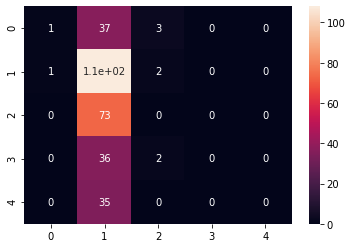

In [56]:
import seaborn as sns
sns.heatmap(confusionmatrix, annot=True)

Confusion matrix, without normalization
[[  1  37   3   0   0]
 [  1 108   2   0   0]
 [  0  73   0   0   0]
 [  0  36   2   0   0]
 [  0  35   0   0   0]]


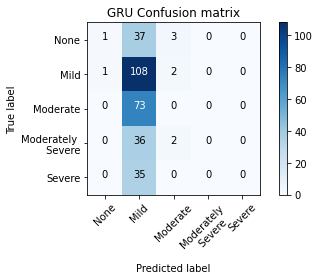

In [57]:
plot_confusion_matrix(confusionmatrix, classes=['None','Mild', 'Moderate', 'Moderately \n Severe', 'Severe'],
                      title='GRU Confusion matrix')

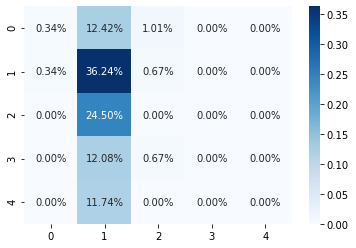

In [59]:
sns.heatmap(confusionmatrix/np.sum(confusionmatrix), annot=True, fmt='.2%', cmap='Blues')

### Training the CNN model

In [54]:
def model2(input_shape):

	model=keras.Sequential()

	# 1st conv layer
	model.add(keras.layers.Conv2D(50, (5,5), activation='relu', input_shape=input_shape))
	model.add(keras.layers.MaxPool2D((2,4), strides=(1,4), padding='same'))
	model.add(keras.layers.BatchNormalization())
	
	# 2nd conv layer
	model.add(keras.layers.Conv2D(100, (5,5), activation='relu', input_shape=input_shape))
	model.add(keras.layers.MaxPool2D((2,3), strides=(1,2), padding='same'))
	model.add(keras.layers.BatchNormalization())


	# 3rd conv layer
	model.add(keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
	model.add(keras.layers.MaxPool2D((2,3), strides=(1,1), padding='same'))
	model.add(keras.layers.BatchNormalization())



	# flatten output & feed to dense layer
	model.add(keras.layers.Flatten())
	model.add(keras.layers.Dense(64, activation='relu'))
	model.add(keras.layers.Dropout(0.3))


	# output layer
	model.add(keras.layers.Dense(5, activation='softmax'))

	return model

In [55]:
# method call
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2], X_train_cnn.shape[3])
# input_shape = (X_train_cnn[0].shape)
model2 = model2(input_shape)

In [56]:
# compile the network
optimizer2 = keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer2,loss="categorical_crossentropy", metrics=['accuracy'])


In [57]:
# training the CNN
hist = model2.fit(X_train_cnn, Y_train_oh,  validation_data=(X_dev_cnn, Y_dev_oh), batch_size=100, epochs=30, callbacks=[early_stopping])

# model_cnn_hist = model_cnn.fit(X_train_cnn, Y_train_oh, validation_data=(X_dev_cnn, Y_dev_oh), epochs = 10, batch_size = 64, shuffle = True, callbacks=[early_stopping, checkpoint_best, checkpoint_epochs])

Epoch 1/30


In [91]:
score = model2.evaluate(X_test_cnn, Y_test_oh, verbose=1)
accuracy1 = 100*score[0]
accuracy2 = 100*score[1]
print('Test loss:  %.4f%%' % accuracy1)
print('Test accuracy:  %.4f%%' % accuracy2)

10/10 [==============================] - 24s 2s/step - loss: 1.5958 - accuracy: 0.3725
Test loss:  159.5831%
Test accuracy:  37.2483%


In [ ]:
plot_acc(model_cnn_hist)
plot_loss(model_cnn_hist)

In [121]:
def model_cnn(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV2D layer 
    X = Conv2D(filters = 50, kernel_size = (5,5), strides=(1, 4), padding='same', data_format="channels_last", activation='relu')(X_input)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 4))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                                 # dropout 

    # Step 2: CONV2D Layer
    X = Conv2D(filters = 100, kernel_size = (5,5), strides=(1, 2), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
    X = MaxPooling2D(pool_size=(2, 3))(X)
    X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
    X = Dropout(rate = 0.4)(X)                              # dropout 

#     # Step 3: CONV2D Layer
#     X = Conv2D(filters = 128, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 3))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.4)(X)   # dropout 
    
#     # Step 4: CONV2D Layer
#     X = Conv2D(filters = 250, kernel_size = (3,3), strides=(1, 1), padding='same', data_format="channels_last", activation='relu')(X)      # CONV2D
#     X = MaxPooling2D(pool_size=(2, 2))(X)
#     X = BatchNormalization(axis=-1)(X)                                 # Batch normalization
#     X = Dropout(rate = 0.2)(X)   # dropout 
    
    # Step 4: Flatten and dense layer
    X = Flatten()(X)
    X = Dense(5, activation = "relu")(X)
    X = Dense(5, activation = "softmax")(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [89]:
model_cnn = model_cnn(input_shape = X_train_cnn[0].shape)
model_cnn.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 95, 2412, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 95, 603, 50)       1300      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 150, 50)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 47, 150, 50)       200       
_________________________________________________________________
dropout_14 (Dropout)         (None, 47, 150, 50)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 75, 100)       125100    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 25, 100)       0   

In [90]:
model_cnn.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [91]:
# log best model
checkpoint_best     = ModelCheckpoint('model_cnn_best',   monitor='loss', verbose=0, save_best_only=True, mode='auto')

# log improved model
checkpoint_epochs   = ModelCheckpoint('model_cnn_epochs', monitor='loss', verbose=0, save_best_only=True, mode='auto')

In [92]:
model_cnn_hist = model_cnn.fit(X_train_cnn, Y_train_oh, validation_data=(X_test_cnn, Y_test_oh), epochs = 100, batch_size = 64, shuffle = True, callbacks=[early_stopping, checkpoint_best, checkpoint_epochs])

Epoch 1/100
21/21 [==============================] - 55s 3s/step - loss: 1.8285 - accuracy: 0.3329 - val_loss: 1.6062 - val_accuracy: 0.3725
INFO:tensorflow:Assets written to: model_cnn_best/assets
INFO:tensorflow:Assets written to: model_cnn_epochs/assets
Epoch 2/100
21/21 [==============================] - 46s 2s/step - loss: 1.6720 - accuracy: 0.3792 - val_loss: 1.5949 - val_accuracy: 0.3725
INFO:tensorflow:Assets written to: model_cnn_best/assets
INFO:tensorflow:Assets written to: model_cnn_epochs/assets
Epoch 3/100
21/21 [==============================] - 46s 2s/step - loss: 1.6161 - accuracy: 0.3791 - val_loss: 1.5881 - val_accuracy: 0.3725
INFO:tensorflow:Assets written to: model_cnn_best/assets
INFO:tensorflow:Assets written to: model_cnn_epochs/assets
Epoch 4/100
21/21 [==============================] - 46s 2s/step - loss: 1.6203 - accuracy: 0.3779 - val_loss: 1.

In [93]:
score = model_cnn.evaluate(X_test_cnn, Y_test_oh, verbose=1)
accuracy1 = 100*score[0]
accuracy2 = 100*score[1]
print('Test loss:  %.4f%%' % accuracy1)
print('Test accuracy:  %.4f%%' % accuracy2)

10/10 [==============================] - 2s 202ms/step - loss: 1.4995 - accuracy: 0.3725
Test loss:  149.9524%
Test accuracy:  37.2483%


In [91]:
Y_predict = model_cnn.predict(X_test_cnn) 
cnn_confusionmatrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), Y_predict.argmax(axis=1))
print(cnn_confusionmatrix)

[[  0  41   0   0   0]
 [  0 111   0   0   0]
 [  0  73   0   0   0]
 [  0  38   0   0   0]
 [  0  35   0   0   0]]


Confusion matrix, without normalization
[[  0  41   0   0   0]
 [  0 111   0   0   0]
 [  0  73   0   0   0]
 [  0  38   0   0   0]
 [  0  35   0   0   0]]


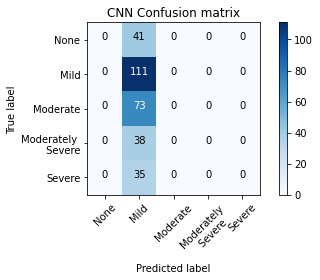

In [92]:
plot_confusion_matrix(cnn_confusionmatrix, classes=['None','Mild', 'Moderate', 'Moderately \n Severe', 'Severe'],
                      title='CNN Confusion matrix')

In [96]:
#Saving the cnn model
with open('./depression-detection-extract/models/model_cnn_hist.json', 'w') as f:
    json.dump(model_cnn_hist.history, f)
model_cnn.save('./depression-detection-extract/models/model_cnn.h5')

In [76]:
def plot_acc(history=model_cnn_hist, title="Model Accuracy"):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Losses Comparison"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Accuracy Comparison"):
    """Compare Accuracies of Two Trainings with Names Name1 and Name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Multiple metrics", metric='accuracy'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

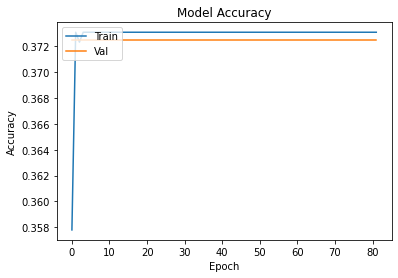

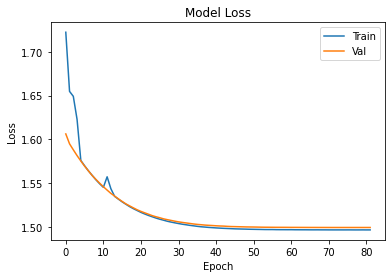

In [95]:
plot_acc(model_cnn_hist)
plot_loss(model_cnn_hist)

### Using ensemble learning to improve on model accuracy
From the above hypothesis, indivdual models are not performing so well. There's<br>
therefore the need to introduce ensemble learning.

Retraining the CNN model but saving multiple models with each iteration <br>
The models would then be combined to try reducing the variance and <br>
generalization error & improve on accuracy

In [97]:
from math import floor
from math import pi
from math import cos
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend

# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
	# constructor
	def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
		self.epochs = n_epochs
		self.cycles = n_cycles
		self.lr_max = lrate_max
		self.lrates = list()
 
	# calculate learning rate for epoch
	def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
		epochs_per_cycle = floor(n_epochs/n_cycles)
		cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
		return lrate_max/2 * (cos(cos_inner) + 1)
 
	# calculate and set learning rate at the start of the epoch
	def on_epoch_begin(self, epoch, logs={}):
		# calculate learning rate
		lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
		# set learning rate
		backend.set_value(self.model.optimizer.lr, lr)
		# log value
		self.lrates.append(lr)
 
	# save models at the end of each cycle
	def on_epoch_end(self, epoch, logs={}):
		# check if we can save model
		epochs_per_cycle = floor(self.epochs / self.cycles)
		if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
			# save model to file
			filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
			self.model.save(filename)
			print('>saved snapshot %s, epoch %d' % (filename, epoch))

In [108]:
opt = SGD(momentum=0.9)

model_cnn2 = model_cnn(input_shape = X_train_cnn[0].shape)
model_cnn2.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])


In [109]:
# create snapshot ensemble callback
n_epochs = 100
n_cycles = n_epochs / 10
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01)

In [112]:
model_cnn2.fit(X_train_cnn, Y_train_oh, validation_data=(X_test_cnn, Y_test_oh), epochs = n_epochs, verbose=0, callbacks=[early_stopping, ca])

>saved snapshot snapshot_model_1.h5, epoch 9
>saved snapshot snapshot_model_2.h5, epoch 19
>saved snapshot snapshot_model_3.h5, epoch 29
>saved snapshot snapshot_model_4.h5, epoch 39
>saved snapshot snapshot_model_5.h5, epoch 49
>saved snapshot snapshot_model_6.h5, epoch 59
>saved snapshot snapshot_model_7.h5, epoch 69
>saved snapshot snapshot_model_8.h5, epoch 79
>saved snapshot snapshot_model_9.h5, epoch 89
>saved snapshot snapshot_model_10.h5, epoch 99


### Load Models and Make Ensemble Prediction

In [134]:
from keras.models import load_model
from numpy import array
from numpy import argmax
from numpy import mean
from numpy import std
import numpy
from sklearn.metrics import accuracy_score

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'snapshot_model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# sum across ensemble members
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	result = argmax(summed, axis=1)
	return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load models in order
members = load_all_models(10)
print('Loaded %d models' % len(members))
# reverse loaded models so we build the ensemble with the last models first
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	# evaluate the i'th model standalone
	testy_enc = to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

(100, 2) (1000, 2)
>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5
>loaded snapshot_model_4.h5
>loaded snapshot_model_5.h5
>loaded snapshot_model_6.h5
>loaded snapshot_model_7.h5
>loaded snapshot_model_8.h5
>loaded snapshot_model_9.h5
>loaded snapshot_model_10.h5
Loaded 10 models
> 1: single=0.756, ensemble=0.756
> 2: single=0.751, ensemble=0.752
> 3: single=0.715, ensemble=0.743
> 4: single=0.655, ensemble=0.715
> 5: single=0.615, ensemble=0.703
> 6: single=0.662, ensemble=0.705
> 7: single=0.721, ensemble=0.704
> 8: single=0.503, ensemble=0.693
> 9: single=0.357, ensemble=0.669
> 10: single=0.685, ensemble=0.674
Accuracy 0.642 (0.118)


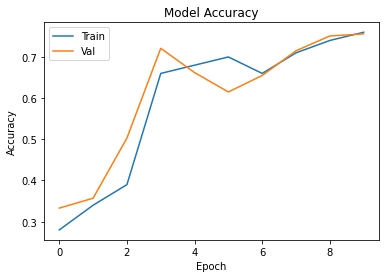

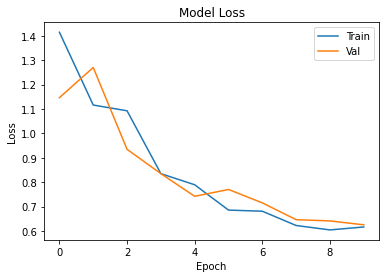

In [133]:
plot_acc(history2)
plot_loss(history2)

### Stacking the ensemble models to a single model

The enseble approach shows improved accuracy. Here the models are <br>
stacked together into a single model.

In [162]:
from numpy import dstack
# from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = lm.LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [163]:
stacked_model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, stacked_model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Stacked Test Accuracy: 0.649


#### Saving the stacked model

In [174]:
import pickle
filename = './depression-detection-extract/models/stacked_model.h5'
pickle.dump(stacked_model, open(filename, 'wb'))


### Converting model to tflite format (for deployment on android)

In [177]:
import tensorflow as tf

model = tf.keras.models.load_model('./depression-detection-extract/models/stacked_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("./depression-detection-extract/models/model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmzml39ii/assets


1661152

### Using quantization to compress the model by reducing weights

In [185]:
converter = tf.lite.TFLiteConverter.from_saved_model('./depression-detection-extract/models/model.tflite')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("./depression-detection-extract/models/model2.tflite", "wb").write(tflite_quant_model)

16